## Handwritten digit recognizer using SVM

A classifier to predict the label of a given digit using PCA and SVM

This kernel aims at building a classifier to predict the label of a handwritten digits using PCA and SVM

<b>Dataset</b>

The dataset consists of images of handwritten numeric digits between 0-9. Each image is of 28 x 28 pixels, i.e. 28 pixels along both length and breadth of the image. Each pixel is an attribute with a numeric value (representing the intensity of the pixel), and thus, there are 784 attributes in the dataset.

It can be found at the kaggle link
https://www.kaggle.com/c/digit-recognizer/data

<b>Problem Statement</b>

The task is to build a classifier that predicts the label of an image (a digit between 0-9) given the features. Thus, this is a 10-class classification problem.
Since this dataset has a large number of features (784), we will use PCA to reduce the dimensionality, and then, build a model on the low-dimensional data.

<b>Solution Overview:</b>

The following topics are covered in this tutorial

<b>Understanding and Exploring the Data
 
Dimensionality Reduction: </b>
PCA will be used to reduce the dimensionality of the dataset.

<b>Model building using SVM on PCA transformed data</b>
Linear, Poly and rbf kernel will be used to build the model and the comparisons will be done.

<b>Hyperparameter tuning and pipelining:</b>
Final model will be built with the help of hyperparameter tuning by cross validation grid search and pipeline functionality.


In [421]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [422]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

### Reading and understanding Data

In [423]:
numbers = pd.read_csv('train.csv')
numbers.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

In [424]:
numbers.shape

(42000, 785)

In [425]:
numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [426]:
numbers.describe(percentiles = [0.05,0.10,0.25,0.50,0.75,0.90,0.99])

label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
5%         0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
10%        1.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
90%        8.000000      0.0      0.0      0.0      0.0      0.0      0.0   
99%        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8   pixel9  pixel10  pixel11      pixel12  \
count  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0  42000.00000   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.00300   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.56812   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.00000   
5%         0.0      0.0      0.0      0.0      0.0      0.0      0.00000   
10%        0.0      0.0      0.0      0.0      0.0      0.0      0.00000   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.00000   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.00000   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.00000   
90%        0.0      0.0      0.0      0.0      0.0      0.0      0.00000   
99%        0.0      0.0      0.0      0.0      0.0      0.0      0.00000   
max        0.0      0.0      0.0      0.0      0.0      0.0    116.00000   

            pixel13       pixel14       pixel15  pixel16  pixel17  pixel18  \
count  42000.000000  42000.000000  42000.000000  42000.0  42000.0  42000.0   
mean       0.011190      0.005143      0.000214      0.0      0.0      0.0   
std        1.626927      1.053972      0.043916      0.0      0.0      0.0   
min        0.000000      0.000000      0.000000      0.0      0.0      0.0   
5%         0.000000      0.000000      0.000000      0.0      0.0      0.0   
10%        0.000000      0.000000      0.000000      0.0      0.0      0.0   
25%        0.000000      0.000000      0.000000      0.0      0.0      0.0   
50%        0.000000      0.000000      0.000000      0.0      0.0      0.0   
75%        0.000000      0.000000      0.000000      0.0      0.0      0.0   
90%        0.000000      0.000000      0.000000      0.0      0.0      0.0   
99%        0.000000      0.000000      0.000000      0.0      0.0      0.0   
max      254.000000    216.000000      9.000000      0.0      0.0      0.0   

       pixel19  pixel20  pixel21  pixel22  pixel23  pixel24  pixel25  pixel26  \
count  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
5%         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
10%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
90%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
99%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0    

### Data Cleaning and Data exploration

In [427]:
#missing value check
sum(numbers.isnull().sum(axis=0))

0

#### No null values in the data. Therefore, we can proceed with the data exploration

In [428]:
numbers['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [429]:
np.unique(numbers['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

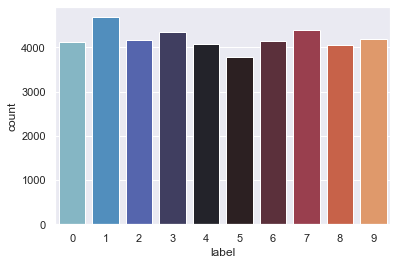

In [430]:
sns.countplot(numbers['label'],palette = 'icefire')

#### There is no data imbalance and the target values are equally distributed

#### Next, lets see how the pixel values are distributed

In [431]:
#Checking average value of all pixels
#round(numbers.drop('label', axis=1).mean(), 2).sort_values(ascending = False)

In [432]:
y = pd.value_counts(numbers.values.ravel()).sort_index()

Text(0, 0.5, 'Frequency')

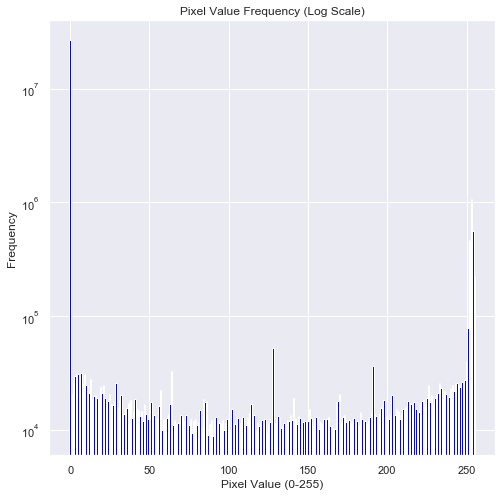

In [433]:
width = 0.9
plt.figure(figsize=[8,8])
plt.bar(range(len(y)),y,width,color="blue")
plt.title('Pixel Value Frequency (Log Scale)')
plt.yscale('log')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Frequency')

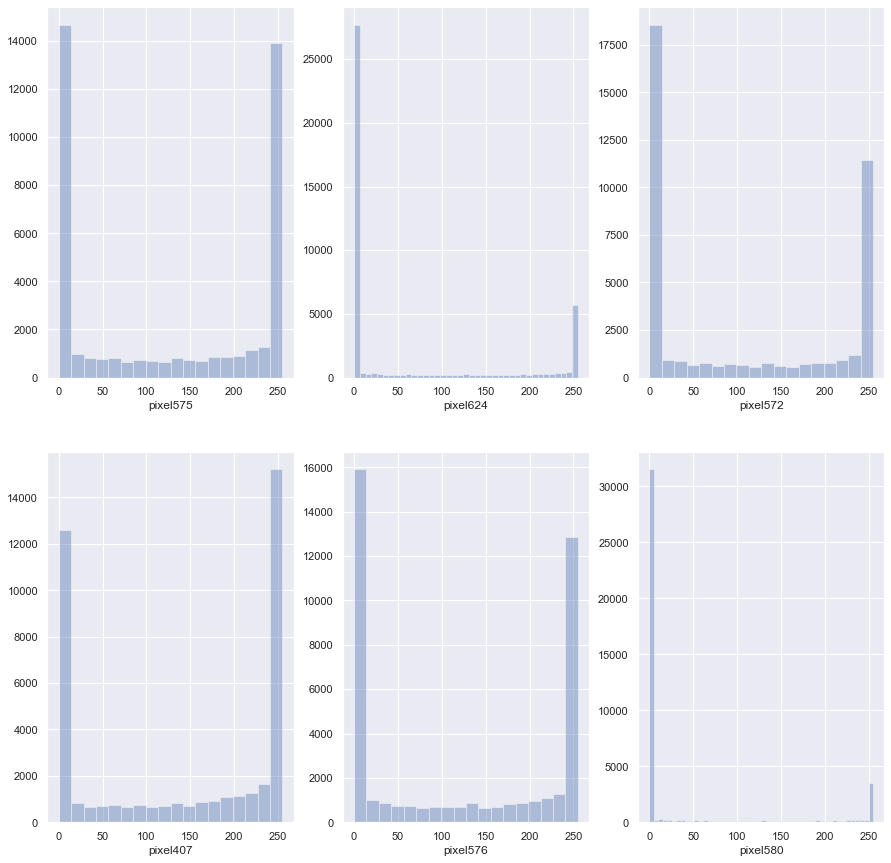

In [434]:
plt.figure(figsize=[15,15])
plt.subplot(2,3,1)
sns.distplot(numbers['pixel575'],kde=False)
plt.subplot(2,3,2)
sns.distplot(numbers['pixel624'],kde=False)
plt.subplot(2,3,3)
sns.distplot(numbers['pixel572'],kde=False)
plt.subplot(2,3,4)
sns.distplot(numbers['pixel407'],kde=False)
plt.subplot(2,3,5)
sns.distplot(numbers['pixel576'],kde=False)
plt.subplot(2,3,6)
sns.distplot(numbers['pixel580'],kde=False)
plt.show()

#### Checking distribution of pixel values with repect to labels

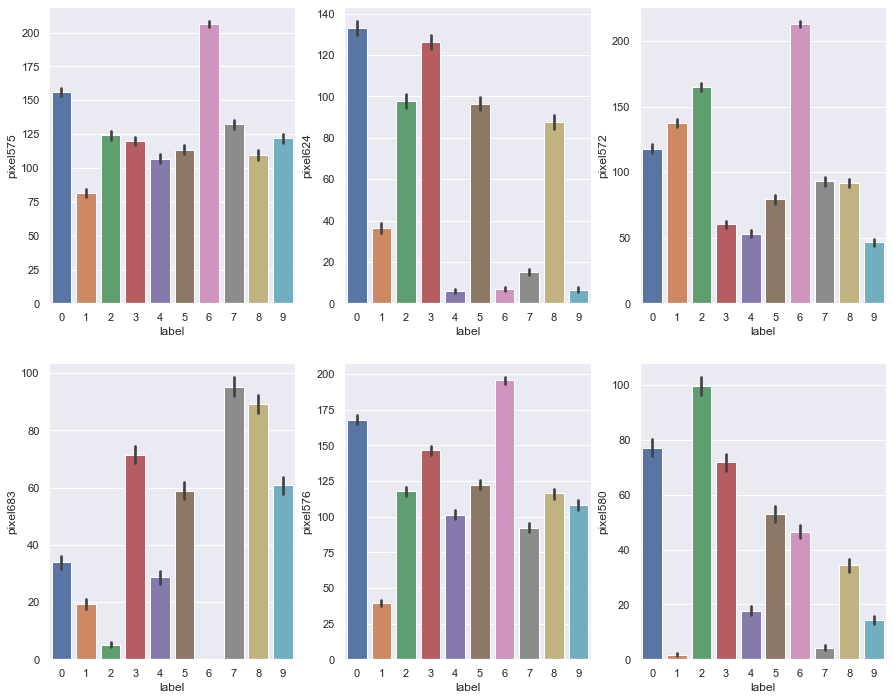

In [435]:
plt.figure(figsize=[15,12])
plt.subplot(2,3,1)
sns.barplot(x='label', y='pixel575', data=numbers)
plt.subplot(2,3,2)
sns.barplot(x='label', y='pixel624', data=numbers)
plt.subplot(2,3,3)
sns.barplot(x='label', y='pixel572', data=numbers)
plt.subplot(2,3,4)
sns.barplot(x='label', y='pixel683', data=numbers)
plt.subplot(2,3,5)
sns.barplot(x='label', y='pixel576', data=numbers)
plt.subplot(2,3,6)
sns.barplot(x='label', y='pixel580', data=numbers)
plt.show()

#### Inferences:
- Label 6 have an average value of 255 for pixel575 and pixel572
- Label 2 have an average value of 100 for pixel580


### Lets visualize how a digit is written in different styles

In [436]:
numbers.loc[numbers['label']==1].head(10).index.values

array([ 0,  2, 12, 15, 35, 37, 38, 41, 52, 59], dtype=int64)

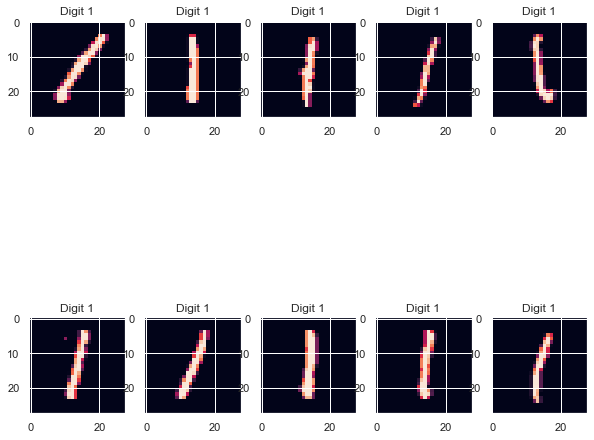

In [437]:
plt.figure(figsize=[10,10])
ones_index = numbers.loc[numbers['label']==1].head(10).index.values
for i in range(0,10):
    one = numbers.iloc[ones_index[i], 1:]
    one = one.values.reshape(28,28)
    plt.subplot(2,5,i+1)
    plt.imshow(one)
    plt.title("Digit 1")

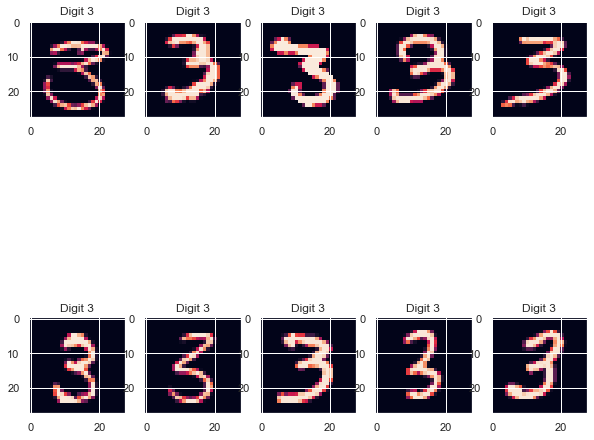

In [438]:
plt.figure(figsize=[10,10])
threes_index = numbers.loc[numbers['label']==3].head(10).index.values
for i in range(0,10):
    one = numbers.iloc[threes_index[i], 1:]
    one = one.values.reshape(28,28)
    plt.subplot(2,5,i+1)
    plt.imshow(one)
    plt.title("Digit 3")

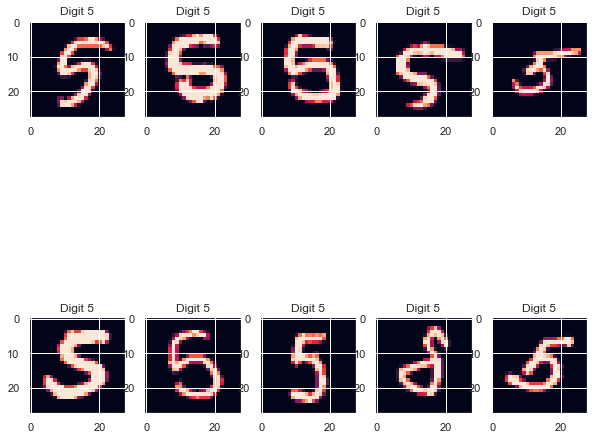

In [439]:
plt.figure(figsize=[10,10])
fives_index = numbers.loc[numbers['label']==5].head(10).index.values
for i in range(0,10):
    one = numbers.iloc[fives_index[i], 1:]
    one = one.values.reshape(28,28)
    plt.subplot(2,5,i+1)
    plt.imshow(one)
    plt.title("Digit 5")

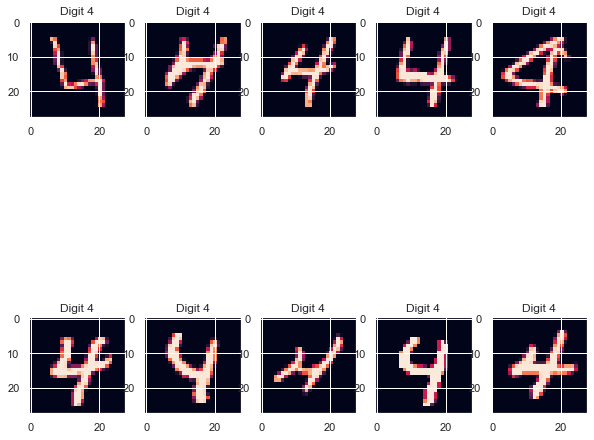

In [440]:
plt.figure(figsize=[10,10])
fours_index = numbers.loc[numbers['label']==4].head(10).index.values
for i in range(0,10):
    one = numbers.iloc[fours_index[i], 1:]
    one = one.values.reshape(28,28)
    plt.subplot(2,5,i+1)
    plt.imshow(one)
    plt.title("Digit 4")

In [441]:
### Heatmap

## Data Preparation
- Splitting data into train and test
- Scaling of the data

In [442]:
y = numbers['label']
X = numbers.drop('label',axis=1)
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [443]:
y[:5]

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [444]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4 ,test_size = 0.6, random_state=100)

In [445]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled = pd.DataFrame(X_train_scaled)
#round(X_train_scaled.describe(),2)

In [446]:
print('X_train shape:',X_train_scaled.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test_scaled.shape)
print('y_test shape:',y_test.shape)

X_train shape: (16800, 784)
y_train shape: (16800,)
X_test shape: (25200, 784)
y_test shape: (25200,)


## Dimensionality Reduction: 
We see that number of pixels are a quite large. Let us first try to reduce the number of features with the help of PCA

#### Appying PCA to reduce the number of  features

In [447]:
pca = PCA(random_state=42)

In [448]:
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [449]:
pca.components_.shape

(784, 784)

In [450]:
#pca.explained_variance_ratio_

In [451]:
var_cummu = np.cumsum(pca.explained_variance_ratio_)

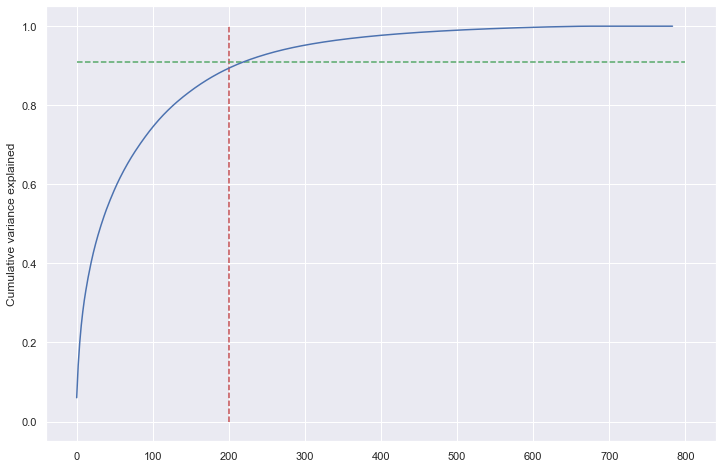

In [452]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[12,8])
plt.vlines(x=200, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.91, xmax=800, xmin=0, colors="g", linestyles="--")
plt.plot(var_cummu)
plt.ylabel("Cumulative variance explained")
plt.show()

We see that 90% of variance is explained by 200 Principal Components.

### Performing PCA with 200 components

In [453]:
pca_final = IncrementalPCA(n_components = 200)

In [454]:
X_train_pca = pca_final.fit_transform(X_train_scaled)

In [455]:
X_train_pca.shape

(16800, 200)

In [456]:
pca_final.components_.shape

(200, 784)

In [457]:
df_train_pca = pd.DataFrame(X_train_pca)
df_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-3.964777,-0.503356,4.220051,1.896184,-2.571804,-0.824517,1.730965,0.586022,-4.995316,1.089721,-1.043468,-0.323320,-0.044300,-0.443121,1.120998,2.513268,-0.999272,1.243606,-1.640128,1.081510,1.357694,2.246812,0.032204,-1.016309,-2.587733,0.826319,-0.295289,2.064519,0.896055,-0.912977,-1.231208,-1.648623,1.469120,-0.039298,0.386224,0.272406,0.069040,-0.114010,2.935096,-0.178704,-1.017235,-1.004964,0.557244,0.411602,0.964131,0.344511,-1.061635,1.213570,0.866186,-0.084890,-0.085434,0.725604,-1.139682,-2.481476,1.271667,0.950856,-0.166631,0.793163,0.358601,-0.597321,0.474877,-0.636487,0.256392,0.770335,0.788619,1.357382,-0.371998,-0.749107,0.197674,-0.990280,-0.921869,-1.154221,-1.155580,0.608689,-1.138200,0.977193,0.150509,-0.158365,-0.348254,-0.231282,-0.203525,-0.267104,0.653781,-0.952742,0.452298,-1.261011,-0.372447,0.848784,-0.511669,0.095172,0.477865,-0.553184,-0.827530,0.689225,0.593402,-0.510552,-0.804445,-0.278802,0.647607,0.293778,1.537714,-0.089126,-1.262653,-0.436754,0.570535,-0.784356,-0.911318,0.960002,-0.315580,0.011012,-0.194655,-0.775376,2.765790,-0.512304,1.778035,0.389269,0.290539,0.744264,-0.765748,0.604221,-0.695961,-0.333626,-0.227937,-0.458766,-0.592404,-0.946800,-0.192727,-0.306379,-0.044216,-0.747608,-0.239284,0.220505,-0.985115,0.465322,0.178498,-0.504528,0.612408,0.291982,-0.180467,-0.424316,-0.579184,-0.058828,-0.803024,0.158439,-0.163896,0.107740,-0.061152,-0.357581,0.600479,-0.332287,0.806904,-0.624671,0.562918,0.122478,-0.748056,0.695339,0.366163,0.424577,-0.297077,0.151020,-0.173093,0.670851,-1.149703,-0.281439,-0.825906,-0.097940,0.641960,0.684901,0.123384,-0.494877,0.719582,-0.054652,-0.701115,-1.057997,-0.003386,-1.557160,0.658276,-0.244226,0.361779,-0.023879,-0.257250,-0.255950,0.591184,-0.619681,0.374872,0.797330,1.448549,-0.637825,-0.380424,0.090617,-1.409617,0.506032,-1.115998,0.128384,0.074309,-1.253305,0.444377,-0.727574,0.630730,0.483193
1,0.071371,-8.781020,0.897155,3.335531,-1.041627,6.697098,-8.726948,4.424063,-9.770225,3.464547,6.441286,4.041017,9.513495,4.832018,-0.698394,1.223302,-1.247425,-3.891353,-0.500199,2.851368,-6.952091,0.148613,-0.367867,6.726541,8.388889,2.149789,-1.668606,-6.500687,7.293051,3.575239,5.098772,2.760316,4.363905,6.342005,4.076159,1.590327,-1.673531,4.461283,-0.407850,1.844540,-3.517574,9.854032,-3.925250,-2.417473,0.495162,-3.058676,-1.285461,-1.650082,1.705822,-7.937513,-5.402741,3.092778,-4.964349,-0.158619,-0.226602,3.368866,-1.315863,-2.223447,1.529061,5.813445,1.483968,-2.001531,2.098864,-3.171404,1.046161,-4.235463,-1.445935,0.439002,-2.126782,-1.650482,-2.020435,3.268659,-2.126800,-2.558268,-3.653666,-0.935716,-2.024090,3.256412,-1.551209,0.304633,-0.033377,2.073924,2.547521,1.434300,2.269166,2.514539,2.376615,2.000077,-0.038376,-1.747767,0.529600,3.726873,-2.463250,0.956456,-0.692682,-3.120895,-2.952588,2.125173,0.927670,2.495820,0.319121,-3.146620,2.081847,-1.765959,-1.441200,2.385040,-0.622995,2.862170,-0.071332,-1.078760,1.246464,1.711948,2.261167,1.368454,0.631703,-2.830786,-0.085920,0.549134,-0.227224,-1.829486,0.608599,-1.809525,-1.218055,0.209877,0.069473,0.228533,-0.195608,0.828448,-0.094561,-0.969612,-0.261603,-0.023766,0.873266,-0.937170,0.103245,1.696202,0.141427,0.525786,1.368697,-0.601640,1.239542,0.715447,-0.379423,-1.200796,-0.386023,0.323502,1.130193,-0.31

In [458]:
y_train_df = pd.DataFrame(y_train)
y_train_df['label'].value_counts()

1    1852
7    1803
2    1708
3    1702
0    1669
4    1661
9    1650
6    1637
8    1631
5    1487
Name: label, dtype: int64

In [459]:
new_df = pd.concat([df_train_pca,y_train_df],axis=1)
new_df['label'].value_counts().sort_index()

0.0    1669
1.0    1852
2.0    1708
3.0    1702
4.0    1661
5.0    1487
6.0    1637
7.0    1803
8.0    1631
9.0    1650
Name: label, dtype: int64

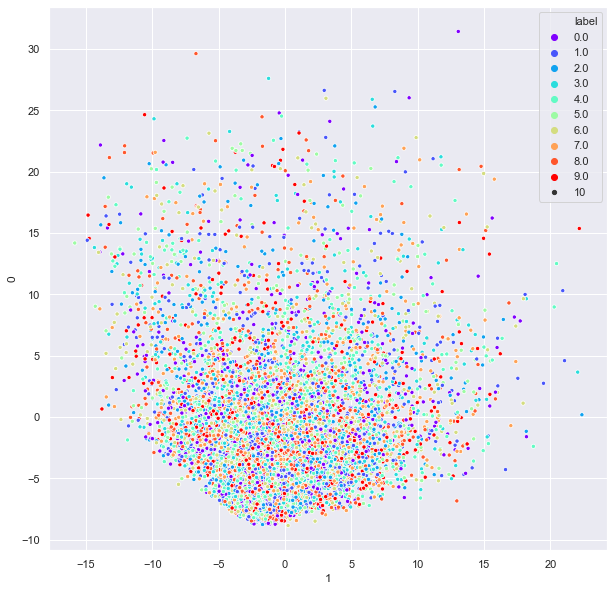

In [460]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=new_df[1],y=new_df[0],hue=new_df['label'],size=10,legend='full',palette='rainbow')

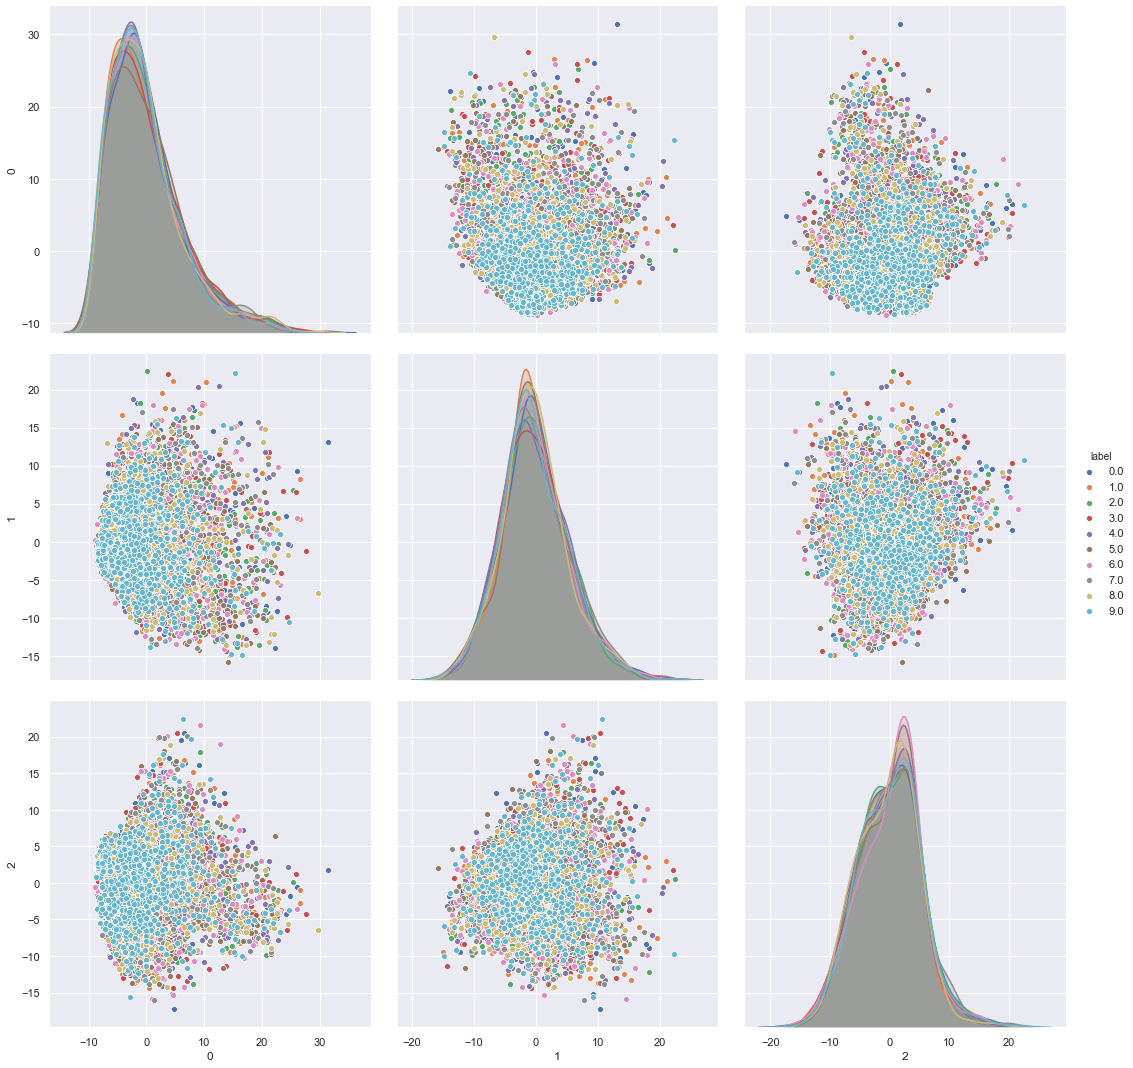

In [461]:
sns.pairplot(data=new_df, x_vars=[0,1,2], y_vars=[0,1,2], hue = "label", size=5)

In [462]:
pca_final.explained_variance_ratio_

array([0.06019314, 0.04260162, 0.03971102, 0.03013203, 0.02694176,
       0.02338798, 0.02006982, 0.01840206, 0.01606551, 0.01494669,
       0.01421551, 0.01281155, 0.01165325, 0.01153231, 0.01087105,
       0.01065779, 0.00986828, 0.00975849, 0.00947434, 0.00923443,
       0.00883564, 0.00848529, 0.00803165, 0.00785181, 0.00749243,
       0.00732549, 0.00720241, 0.00696426, 0.00651424, 0.00644718,
       0.00637191, 0.00630766, 0.00609834, 0.00593451, 0.0058744 ,
       0.00578555, 0.00560783, 0.0055518 , 0.00547936, 0.00523015,
       0.00507064, 0.00501841, 0.00496306, 0.00481782, 0.00478168,
       0.00472011, 0.0046246 , 0.00459758, 0.00457796, 0.00442207,
       0.00441544, 0.00434465, 0.00421813, 0.00415612, 0.00409539,
       0.00405996, 0.0039429 , 0.0038316 , 0.00381698, 0.00373735,
       0.00369082, 0.00366205, 0.00361989, 0.00356789, 0.00354034,
       0.00348658, 0.00337106, 0.00333766, 0.00331445, 0.00327434,
       0.00323249, 0.00318507, 0.00317232, 0.00310283, 0.00305

### Redcucing the dimensions of the test data

In [463]:
X_test_pca = pca_final.transform(X_test_scaled)
X_test_pca.shape

(25200, 200)

#### Till now we have converted our initial scaled data to pca transformed data

    - X_train --> X_train_scaled --> X_train_pca
    - X_test  --> X_test_scaled  --> X_test_pca

### Model building using SVM on PCA transformed data

SVM uses following three kernel to buld a model.

<b>The linear kernel:</b> This gives the linear support vector classifier, or the hyperplane.

<b>The polynomial kernel:</b> It is capable of creating nonlinear, polynomial decision boundaries 

<b>The radial basis function (RBF) kernel:</b> This is the most complex one, which is capable of transforming highly nonlinear feature spaces to linear ones. It is even capable of creating elliptical (i.e. enclosed) decision boundaries


#### Let us first try linear model

In [464]:
# linear model
model_linear = SVC(kernel='linear')
model_linear.fit(X_train_pca, y_train)

# predict
y_train_pred = model_linear.predict(X_train_pca)
y_test_pred = model_linear.predict(X_test_pca)

#### We just built our first SVM model using a `linear` kernel. Its time to evaluate our model using Accuracy as our evauation metric

In [465]:
train_accuracy = metrics.accuracy_score(y_train,y_train_pred)
print("Accuracy on training data: {}".format(train_accuracy))
test_accuracy = metrics.accuracy_score(y_test,y_test_pred)
print("Accuracy on testing data: {}".format(test_accuracy))

print("\nClassification report on testing set \n")
print(metrics.classification_report(y_test, y_test_pred))

print("\nConfusion metrics on testing set \n")
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred))

Accuracy on training data: 0.9823809523809524
Accuracy on testing data: 0.9197619047619048

Classification report on testing set 

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2463
           1       0.97      0.97      0.97      2832
           2       0.88      0.91      0.89      2469
           3       0.89      0.91      0.90      2649
           4       0.91      0.92      0.91      2411
           5       0.90      0.88      0.89      2308
           6       0.95      0.93      0.94      2500
           7       0.94      0.93      0.93      2598
           8       0.92      0.88      0.90      2432
           9       0.91      0.89      0.90      2538

    accuracy                           0.92     25200
   macro avg       0.92      0.92      0.92     25200
weighted avg       0.92      0.92      0.92     25200


Confusion metrics on testing set 

[[2394    0    8    8    7   17   19    2    5    3]
 [   0 2742   23   12

#### The linear model gives approx. 91.9% testing accuracy. Whereas our training data shows an accuracy of 98.2%. 

#### Let's look at a non-linear model with randomly chosen hyperparameters.


Trying `poly` kernel

In [466]:
# non-linear model
# using poly kernel, C=1, default value of gamma

# model
non_linear_model_poly = SVC(kernel='poly')
non_linear_model_poly.fit(X_train_pca, y_train)

# predict
y_train_pred = non_linear_model_poly.predict(X_train_pca)
y_test_pred = non_linear_model_poly.predict(X_test_pca)

#### Lets evaluate our model using Accuracy as our evauation metric

In [467]:
train_accuracy = metrics.accuracy_score(y_train,y_train_pred)
print("Accuracy on training data: {}".format(train_accuracy))
test_accuracy = metrics.accuracy_score(y_test,y_test_pred)
print("Accuracy on testing data: {}".format(test_accuracy))

print("\nClassification report on testing set \n")
print(metrics.classification_report(y_test, y_test_pred))
print("\nConfusion metrics on testing set \n")
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred))

Accuracy on training data: 0.9988690476190476
Accuracy on testing data: 0.9662698412698413

Classification report on testing set 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2463
           1       0.99      0.98      0.99      2832
           2       0.96      0.96      0.96      2469
           3       0.96      0.96      0.96      2649
           4       0.96      0.97      0.96      2411
           5       0.97      0.95      0.96      2308
           6       0.98      0.98      0.98      2500
           7       0.98      0.96      0.97      2598
           8       0.94      0.96      0.95      2432
           9       0.95      0.95      0.95      2538

    accuracy                           0.97     25200
   macro avg       0.97      0.97      0.97     25200
weighted avg       0.97      0.97      0.97     25200


Confusion metrics on testing set 

[[2425    0    5    2    4    4   13    0    5    5]
 [   1 2783   17    4

#### The accuracy increased to 96.62, so obviously no point in going with linear. Let us try 'rbf'.

#### Trying `rbf` kernel

In [468]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model_poly = SVC(kernel='rbf')
non_linear_model_poly.fit(X_train_pca, y_train)

# predict
y_train_pred = non_linear_model_poly.predict(X_train_pca)
y_test_pred = non_linear_model_poly.predict(X_test_pca)

In [469]:
train_accuracy = metrics.accuracy_score(y_train,y_train_pred)
print("Accuracy on training data: {}".format(train_accuracy))
test_accuracy = metrics.accuracy_score(y_test,y_test_pred)
print("Accuracy on testing data: {}".format(test_accuracy))

print("\nClassification report on testing set \n")
print(metrics.classification_report(y_test, y_test_pred))
print("\nConfusion metrics on testing set \n")
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred))

Accuracy on training data: 0.9955357142857143
Accuracy on testing data: 0.9291666666666667

Classification report on testing set 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2463
           1       0.99      0.97      0.98      2832
           2       0.69      0.98      0.81      2469
           3       0.96      0.90      0.93      2649
           4       0.97      0.91      0.94      2411
           5       0.97      0.92      0.94      2308
           6       0.97      0.93      0.95      2500
           7       0.95      0.91      0.93      2598
           8       0.97      0.92      0.94      2432
           9       0.96      0.90      0.93      2538

    accuracy                           0.93     25200
   macro avg       0.94      0.93      0.93     25200
weighted avg       0.94      0.93      0.93     25200


Confusion metrics on testing set 

[[2355    0   88    0    2    5    9    1    2    1]
 [   0 2753   32    8

#### Accuracy is descreased by using rbf model. Lets go forward with poly kernel model.

Till now, after PCA transformation with 200 components, we tried SVM using 3 different kernels and using default hyperparamters (C and gamma)
We finialized that `PCA transformed` data along with `poly` SVM kernel gives us an accuracy of 96%.

Therefore, to further fine tune our model we can consider following changes:
- Trying different number of PCA components. We can connsider using 195 and 200 components.
- Trying different values of hyperparameter C. The value of C tells us how much you want to avoid misclassifying on training data. We can consider C as 1, 10.
- Trying different values of hyperparameter gamma. The hyperparameter gamma controls  the amount of non-linearity in the model - as gamma increases, the model becomes more non-linear, and thus model complexity increases. We can consider gamma as 0.1,0.01.
    
Now we want to know what should be the best combination of values of number PCA compnents, C and gamma for our model built using `poly` kernel of SVM.

We will be using grid search cross validation to find the best comnination of the hyperparamters.

Along with this, we will introduce the pipelining functionality of sklearn.

Till now the steps we did include:

1. Scale the initial data
2. Perform PCA to reduce the dimensionality
3. Build a model using SVM.

A pipeline, will schedule all the above steps and create the final model in our gridSearch.

#### Using Pipeline for performing scaling, PCA and SVM on the Data

In [470]:
pipe_steps = [('scaler',StandardScaler()),('pca',PCA()),('SVM',SVC(kernel='poly'))]
check_params = {
    'pca__n_components' : [195,200],
    'SVM__C':[1,10],
    'SVM__gamma':[0.01,0.001]
}

pipeline = Pipeline(pipe_steps)

Now, gridSearch will be used to find the best combbiantion of parameters. In the above pipeline, for every value of PCA number of components, the grid search will build model 4 models.

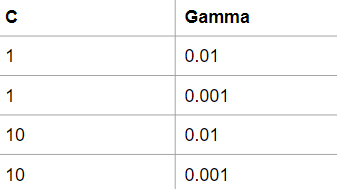

As we are considering, 2 values for PCA components, therefore, GridSearch will build 8 different models. 

For the 8 different models, we will be using KFold cross validation with 3 splits. Therefore, the training will be done on 8X3 = 24 different models fits.

Now lets get our final parameters for the model.

In [471]:
folds = KFold(n_splits=3,shuffle=True,random_state=101)


#setting up GridSearchCV()
model_cv = GridSearchCV(estimator = pipeline,
                       param_grid = check_params,
                       scoring = 'accuracy',
                       cv = folds,
                       verbose = 3,
                       return_train_score=True,
                       n_jobs=-1)

#fit the model
model_cv.fit(X_train,y_train) # Considering our initial data as scaling will be handled by the pipeline.
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  8.9min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 11.4min finished


The best test score is 0.9608928571428571 corresponding to hyperparameters {'SVM__C': 1, 'SVM__gamma': 0.01, 'pca__n_components': 200}


In [472]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVM__C,param_SVM__gamma,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,89.106339,7.477134,26.685667,0.558990,1,0.01,195,"{'SVM__C': 1, 'SVM__gamma': 0.01, 'pca__n_comp...",0.961786,0.959464,0.960179,0.960476,0.000971,4,1.000000,1.000000,1.000000,1.000000,0.000000
1,87.020339,5.292988,27.669001,0.736422,1,0.01,200,"{'SVM__C': 1, 'SVM__gamma': 0.01, 'pca__n_comp...",0.962321,0.959643,0.960714,0.960893,0.001101,1,1.000000,1.000000,1.000000,1.000000,0.000000
2,200.794002,8.521161,49.049001,4.657374,1,0.001,195,"{'SVM__C': 1, 'SVM__gamma': 0.001, 'pca__n_com...",0.826071,0.821964,0.810536,0.819524,0.006573,8,0.847768,0.843661,0.850714,0.847381,0.002893
3,211.044998,6.140366,50.019331,4.347977,1,0.001,200,"{'SVM__C': 1, 'SVM__gamma': 0.001, 'pca__n_com...",0.826607,0.822143,0.810357,0.819702,0.006855,7,0.848482,0.844107,0.851250,0.847946,0.002941
4,88.876000,1.405391,25.896335,0.837131,10,0.01,195,"{'SVM__C': 10, 'SVM__gamma': 0.01, 'pca__n_com...",0.961607,0.959643,0.960893,0.960714,0.000812,2,1.000000,1.000000,1.000000,1.000000,0.000000
5,87.696336,1.364465,27.132332,1.696222,10,0.01,200,"{'SVM__C': 10, 'SVM__gamma': 0.01, 'pca__n_com...",0.961429,0.959643,0.960714,0.960595,0.000734,3,1.000000,1.000000,1.000000,1.000000,0.000000
6,94.154997,4.861868,23.978998,1.529411,10,0.001,195,"{'SVM__C': 10, 'SVM__gamma': 0.001, 'pca__n_co...",0.945357,0.947321,0.942321,0.945000,0.002057,6,0.978929,0.977232,0.977321,0.977827,0.000780
7,95.728666,1.802553,24.836334,1.709247,10,0.001,200,"{'SVM__C': 10, 'SVM__gamma': 0.001, 'pca__n_co...",0.945179,0.947857,0.942500,0.945179,0.002187,5,0.978929,0.977589,0.977768,0.978095,0.000594


<b>The above table gives the results for 24 different model fits that were done by the grid Search. The best parameteres are selected based on the `mean_train_score` and `mean_test_score` as shown in the above table.


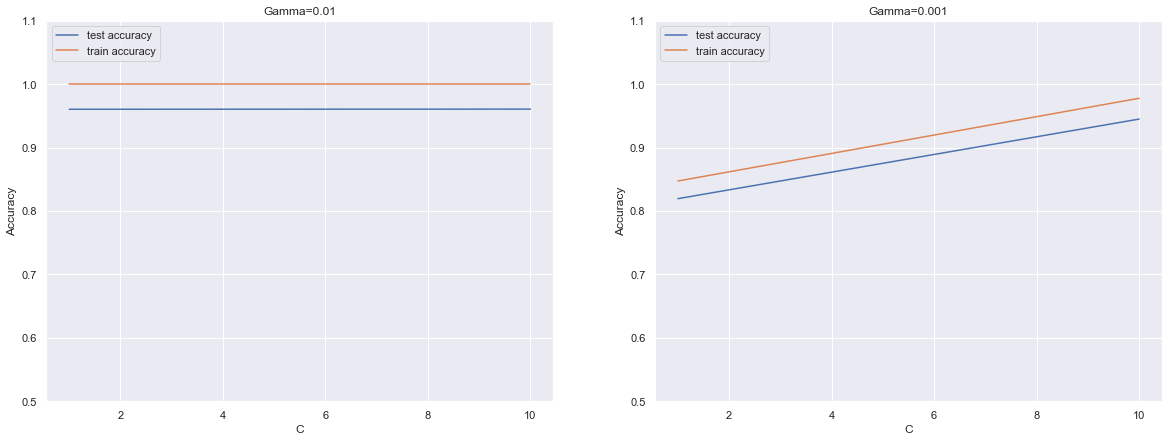

In [473]:
# converting C to numeric type for plotting on x-axis
cv_results['param_SVM__C'] = cv_results['param_SVM__C'].astype('int')

# # plotting
plt.figure(figsize=(20,7))

# subplot 1/3
plt.subplot(121)
gamma_01 = cv_results[(cv_results['param_SVM__gamma']==0.01) & (cv_results['param_pca__n_components'] == 195)]

plt.plot(gamma_01["param_SVM__C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_SVM__C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.50, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')


# subplot 2/3
plt.subplot(122)
gamma_001 = cv_results[(cv_results['param_SVM__gamma']==0.001) & (cv_results['param_pca__n_components'] == 195)]

plt.plot(gamma_001["param_SVM__C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_SVM__C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.50, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')



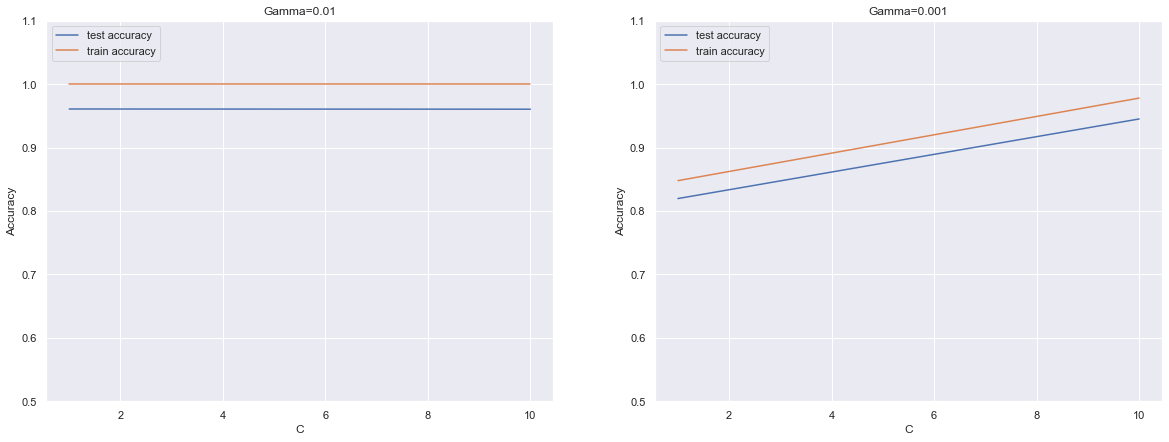

In [474]:
# # plotting
plt.figure(figsize=(20,7))

# subplot 1/3
plt.subplot(121)
gamma_01 = cv_results[(cv_results['param_SVM__gamma']==0.01) & (cv_results['param_pca__n_components'] == 200)]

plt.plot(gamma_01["param_SVM__C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_SVM__C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.50, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')


# subplot 2/3
plt.subplot(122)
gamma_001 = cv_results[(cv_results['param_SVM__gamma']==0.001) & (cv_results['param_pca__n_components'] == 200)]

plt.plot(gamma_001["param_SVM__C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_SVM__C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.50, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')

#### Now we have the best values of hyper parameters. 
### Let us build the final model using these values and evaluate the results.

In [488]:
pca_final = IncrementalPCA(n_components = 200)

X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)
print(X_test_pca.shape)
print(X_train_pca.shape)

(25200, 200)
(16800, 200)


In [489]:
# model with optimal hyperparameters

# model
final_model = SVC(C=1, gamma=0.01, kernel="poly")

final_model.fit(X_train_pca, y_train)
# predict
y_train_pred = final_model.predict(X_train_pca)
y_test_pred = final_model.predict(X_test_pca)

In [490]:
# metrics
train_accuracy = metrics.accuracy_score(y_train,y_train_pred)
print("Accuracy on training data: {}".format(train_accuracy))
test_accuracy = metrics.accuracy_score(y_test,y_test_pred)
print("Accuracy on testing data: {}".format(test_accuracy))

print("\nClassification report on testing set \n")
print(metrics.classification_report(y_test, y_test_pred))

print("\nConfusion metrics on testing set \n")
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_test_pred))

Accuracy on training data: 1.0
Accuracy on testing data: 0.9651984126984127

Classification report on testing set 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2463
           1       0.99      0.98      0.99      2832
           2       0.95      0.96      0.96      2469
           3       0.96      0.96      0.96      2649
           4       0.96      0.97      0.96      2411
           5       0.96      0.95      0.96      2308
           6       0.98      0.98      0.98      2500
           7       0.97      0.96      0.97      2598
           8       0.94      0.96      0.95      2432
           9       0.95      0.95      0.95      2538

    accuracy                           0.97     25200
   macro avg       0.96      0.96      0.96     25200
weighted avg       0.97      0.97      0.97     25200


Confusion metrics on testing set 

[[2426    0    5    2    4    4   13    0    5    4]
 [   1 2777   17    5    4    2    4

### Using final model on unseen data (test.csv)

In [491]:
#import file and reading few lines
test_df = pd.read_csv('test.csv')
test_df.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

In [479]:
test_df.shape

(28000, 784)

In [492]:
test_scaled = scaler.transform(test_df)

In [493]:
final_test_pca = pca_final.transform(test_scaled)
final_test_pca.shape

(28000, 200)

In [494]:
#model.predict
test_predict = final_model.predict(final_test_pca)

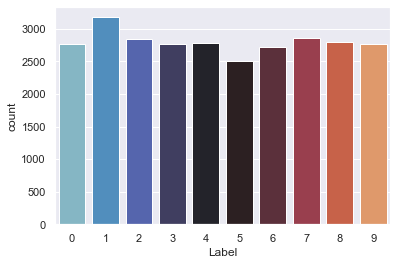

In [496]:
# Plotting the distribution of prediction
a = {'ImageId': np.arange(1,test_predict.shape[0]+1), 'Label': test_predict}
data_to_export = pd.DataFrame(a)
sns.countplot(data_to_export['Label'], palette = 'icefire')

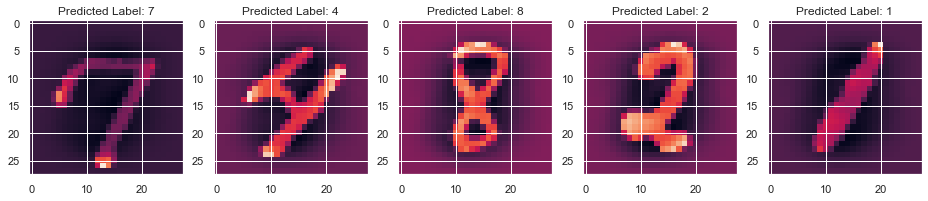

In [497]:
# Let us visualize few of predicted test numbers
df = np.random.randint(1,test_predict.shape[0]+1,5)

plt.figure(figsize=(16,4))
for i,j in enumerate(df):
    plt.subplot(150+i+1)
    d = test_scaled[j].reshape(28,28)
    plt.title(f'Predicted Label: {test_predict[j]}')
    plt.imshow(d)
plt.show()

In [498]:
# Exporting the predicted values 
data_to_export.to_csv(path_or_buf='submission.csv', index=False)

In [499]:
submitted = pd.read_csv('submission.csv')

In [500]:
submitted.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
